In [3]:
import numpy as np
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
model_iMM904 = read_sbml_model('iMM904.xml')
phy = Metabolite(id='phy', name='phytoene', compartment='c') #Adding the metabolite
new_reaction1 = Reaction('phy_syn') #PHYtoene SYNtase
phy = Metabolite(id='phy', name='phytoene', compartment='c') #Adding the metabolite

new_reaction1.add_metabolites({model_iMM904.metabolites.ggdp_c: -2,
                              phy: 1, # our newly created metabolites
                               model_iMM904.metabolites.ppi_c: 2
                                })
model_iMM904.add_reactions([new_reaction1])
new_reaction2 = Reaction('neu_syn') #NEUrosporene SYNtase
#Adding the metabolite
neu = Metabolite(id='neu', name='Neurosporene', compartment='c') 
#AH2 = Metabolite(id='AH2', name='Reduced acceptor', compartment='c') 
#A = Metabolite(id='A', name='Acceptor', compartment='c') 
new_reaction2.add_metabolites({
    model_iMM904.metabolites.nadp_c: -3,
    phy: -1, # our newly created metabolites
    model_iMM904.metabolites.nadph_c: 3,
    neu: 1,
    })
model_iMM904.add_reactions([new_reaction2])
new_reaction3 = Reaction('lyc_syn') #LYCopene SYNtase
lyc = Metabolite(id='lyc', name='Lycopene', compartment='c') #Adding the metabolite
new_reaction3.add_metabolites({
    neu: -1, # our newly created metabolites
    model_iMM904.metabolites.nadph_c: -1, 
    model_iMM904.metabolites.o2_c: -1,
    lyc: 1,
    model_iMM904.metabolites.nadp_c: 1,
    model_iMM904.metabolites.h2o_c: 2,
    })
model_iMM904.add_reactions([new_reaction3])
new_reaction4 = Reaction('beta_syn') #BETA-carotene SYNtase
beta = Metabolite(id='beta', name='Beta-carotene', compartment='c', formula ='C40H56') #Adding the metabolite
new_reaction4.add_metabolites({
    lyc: -1, # our newly created metabolites
    beta: 1,
    })
model_iMM904.add_reactions([new_reaction4])
new_reaction5 = Reaction('EX_beta') #BETA-carotene SYNtase
new_reaction5.add_metabolites({
    beta: -1 #Excretion of beta-carotene
    })
model_iMM904.add_reactions([new_reaction5])
with model_iMM904:
    model_iMM904.objective = model_iMM904.reactions.EX_beta 
    print("Maximum beta-carotene flow: ",model_iMM904.optimize().objective_value)

Maximum beta-carotene flow:  0.35143769968051247


In [4]:
print(model_iMM904.metabolites.beta.elements)

{'C': 40, 'H': 56}


In [5]:
C = 12
H = 1
N = 14
O = 16
biomass_weight = C*47.5+H*7+N*9.25 #g/mol - this is the median measured
beta_weight = model_iMM904.metabolites.beta.elements['C']*C+model_iMM904.metabolites.beta.elements['H']*H #g/mol
gxtsn_e_weight = model_iMM904.metabolites.xtsn_e.elements['C']*C+model_iMM904.metabolites.xtsn_e.elements['H']*H+model_iMM904.metabolites.xtsn_e.elements['O']*O+model_iMM904.metabolites.xtsn_e.elements['N']*N
glucose_weight = model_iMM904.metabolites.glc__D_c.elements['C']*C+model_iMM904.metabolites.glc__D_c.elements['H']*H+model_iMM904.metabolites.glc__D_c.elements['O']*O
    

In [6]:
genes_for_kncokout = ['GAPD','PYK','ARGN','ARGN', 'PYRDC']

In [7]:
print(type(genes_for_kncokout[0]))

<class 'str'>


In [8]:
model_iMM904.reactions.get_by_id(genes_for_kncokout[0])

Reaction identifier,GAPD
Name,Glyceraldehyde-3-phosphate dehydrogenase
Memory address,0x07fb3d9e7df10
Stoichiometry,g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c Glyceraldehyde 3-phosphate + Nicotinamide adenine dinucleotide + Phosphate <=> 3-Phospho-D-glyceroyl phosphate + H+ + Nicotinamide adenine dinucleotide - reduced
GPR,YJL052W or YJR009C or YGR192C
Lower bound,-999999.0
Upper bound,999999.0


In [24]:
model_iMM904.objective = model_iMM904.reactions.BIOMASS_SC5_notrace 
solution = model_iMM904.optimize()
max_growth_flux = model_iMM904.optimize().objective_value

different_Growth = [max_growth_flux*0.01,max_growth_flux*0.1,max_growth_flux*0.2,max_growth_flux*0.3, max_growth_flux*0.4,max_growth_flux*0.5,max_growth_flux*0.6,max_growth_flux*0.7, max_growth_flux*0.8, max_growth_flux*0.9, max_growth_flux*0.999]
difference_beta_yield = []
difference_beta_yield_glc = []
difference_beta_flux = []
difference_growth_yield = []
for i in range(len(different_Growth)):
    with model_iMM904:
        print("\033[1m\nYield when biomass flux is", different_Growth[i], ".\033[0m")
        model_iMM904.reactions.BIOMASS_SC5_notrace.bounds = different_Growth[i],different_Growth[i]+0.0001
        model_iMM904.objective = model_iMM904.reactions.BIOMASS_SC5_notrace 
        solution = model_iMM904.optimize()
        max_growth_flux = model_iMM904.optimize().objective_value
        yield_X_glc_mol = max_growth_flux/abs(solution.fluxes["EX_glc__D_e"])
        difference_growth_yield.append(yield_X_glc_mol)

        model_iMM904.objective = model_iMM904.reactions.EX_beta 
        solution_beta = model_iMM904.optimize()
        max_beta_flux = model_iMM904.optimize().objective_value 

        print('Investigation of maximum beta-carotene yield with a growth flux of :', round(max_growth_flux*0.999,2))
        yield_b_glc_g = (max_beta_flux /abs(solution_beta.fluxes["EX_glc__D_e"]))*(beta_weight/glucose_weight)
        yield_b_glc_mol = max_beta_flux /abs(solution_beta.fluxes["EX_glc__D_e"])
        yield_b_X_g = (max_beta_flux /abs(solution_beta.fluxes["BIOMASS_SC5_notrace"]))*(beta_weight/biomass_weight)
        yield_b_X_mol = max_beta_flux /abs(solution_beta.fluxes["BIOMASS_SC5_notrace"])
        difference_beta_yield.append(yield_b_X_mol)
        difference_beta_flux.append(max_beta_flux)
        difference_beta_yield_glc.append(yield_b_glc_mol)
print(difference_beta_yield)
print(difference_beta_flux)
print(difference_beta_yield_glc)
print(difference_growth_yield)


Yield when biomass flux is 0.0028786570370401554 .
Investigation of maximum beta-carotene yield with a growth flux of : 0.0

Yield when biomass flux is 0.028786570370401554 .
Investigation of maximum beta-carotene yield with a growth flux of : 0.03

Yield when biomass flux is 0.05757314074080311 .
Investigation of maximum beta-carotene yield with a growth flux of : 0.06

Yield when biomass flux is 0.08635971111120466 .
Investigation of maximum beta-carotene yield with a growth flux of : 0.09

Yield when biomass flux is 0.11514628148160622 .
Investigation of maximum beta-carotene yield with a growth flux of : 0.12

Yield when biomass flux is 0.14393285185200777 .
Investigation of maximum beta-carotene yield with a growth flux of : 0.14

Yield when biomass flux is 0.17271942222240932 .
Investigation of maximum beta-carotene yield with a growth flux of : 0.17

Yield when biomass flux is 0.20150599259281088 .
Investigation of maximum beta-carotene yield with a growth flux of : 0.2

Yield 

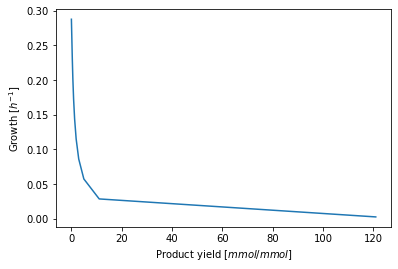

In [21]:

import matplotlib.pyplot as plt
plt.plot(difference_beta_yield, different_Growth)
plt.xlabel('Product yield [$mmol / mmol$]')
plt.ylabel('Growth [$h^{-1}$]')
plt.show()

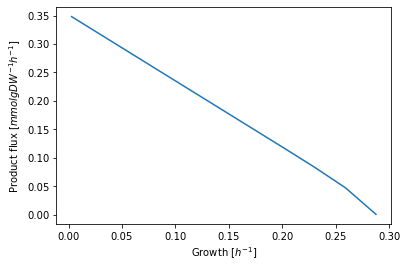

In [22]:
import matplotlib.pyplot as plt
plt.plot(different_Growth, difference_beta_flux)
plt.xlabel('Growth [$h^{-1}$]')
plt.ylabel('Product flux [$mmol gDW^{-1} h^{-1}$]')
plt.show()

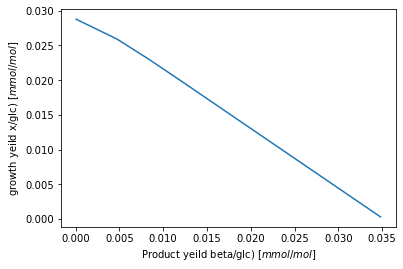

In [23]:
import matplotlib.pyplot as plt
plt.plot(difference_beta_yield_glc,difference_growth_yield)
plt.xlabel('Product yeild beta/glc) [$mmol/mol$]')
plt.ylabel('growth yeild x/glc) [$mmol/mol$]')
plt.show()